In [45]:
import numpy as np
import random
import os

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import warnings

# 경고 무시
warnings.filterwarnings("ignore", category=FutureWarning)

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN

In [47]:
import pandas as pd

train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

In [48]:
train_df.loc[train_df['대출등급'] == 'A','대출등급'] = 0
train_df.loc[train_df['대출등급'] == 'B','대출등급'] = 1
train_df.loc[train_df['대출등급'] == 'C','대출등급'] = 2
train_df.loc[train_df['대출등급'] == 'D','대출등급'] = 3
train_df.loc[train_df['대출등급'] == 'E','대출등급'] = 4
train_df.loc[train_df['대출등급'] == 'F','대출등급'] = 5
train_df.loc[train_df['대출등급'] == 'G','대출등급'] = 6

train_df['대출등급']= train_df['대출등급'].astype('int64')

In [49]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96294 entries, 0 to 96293
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            96294 non-null  object 
 1   대출금액          96294 non-null  int64  
 2   대출기간          96294 non-null  object 
 3   근로기간          96294 non-null  object 
 4   주택소유상태        96294 non-null  object 
 5   연간소득          96294 non-null  int64  
 6   부채_대비_소득_비율   96294 non-null  float64
 7   총계좌수          96294 non-null  int64  
 8   대출목적          96294 non-null  object 
 9   최근_2년간_연체_횟수  96294 non-null  int64  
 10  총상환원금         96294 non-null  int64  
 11  총상환이자         96294 non-null  float64
 12  총연체금액         96294 non-null  float64
 13  연체계좌수         96294 non-null  float64
 14  대출등급          96294 non-null  int64  
dtypes: float64(4), int64(6), object(5)
memory usage: 11.0+ MB


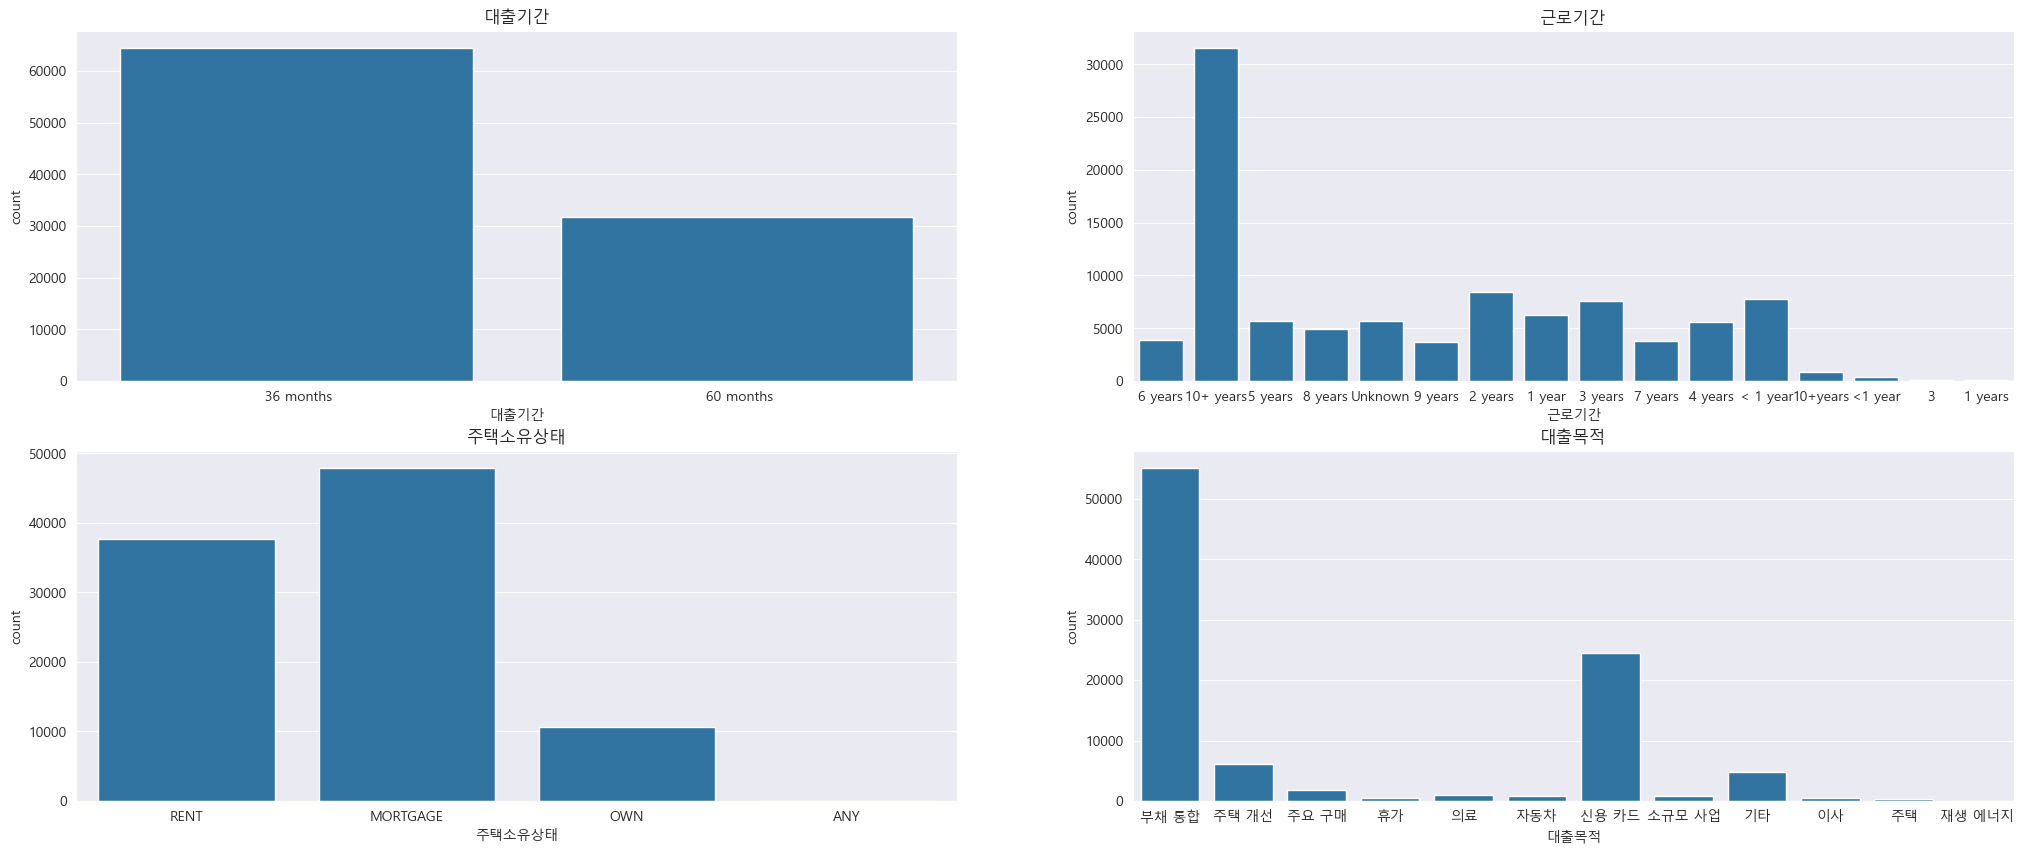

In [50]:
# 시각화 패키지 불러오기
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
# 한글 폰트 설정하기
fe = fm.FontEntry(fname = 'Malgun Gothic', name = 'Malgun Gothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rc('font', family='Malgun Gothic')

fig, axes = plt.subplots(2, 2, figsize=(25,10)) # 2x2 형식으로 4개 그래프 동시에 표시

sns.countplot(x = train_df['대출기간'], ax=axes[0][0]).set_title('대출기간')
sns.countplot(x = train_df['근로기간'], ax=axes[0][1]).set_title('근로기간')
sns.countplot(x = train_df['주택소유상태'], ax=axes[1][0]).set_title('주택소유상태')
sns.countplot(x = train_df['대출목적'], ax=axes[1][1]).set_title('대출목적')

plt.show()

In [51]:
train_x = train_df.drop(columns=['ID', '근로기간', '대출등급'])
train_y = train_df['대출등급']

test_x = test_df.drop(columns=['ID', '근로기간'])

In [52]:
from sklearn.preprocessing import LabelEncoder

categorical_features = ['대출기간', '주택소유상태', '대출목적']

for i in categorical_features:
    le = LabelEncoder()
    le=le.fit(train_x[i])
    train_x[i]=le.transform(train_x[i])

    for case in np.unique(test_x[i]):
        if case not in le.classes_:
            le.classes_ = np.append(le.classes_, case)
    test_x[i]=le.transform(test_x[i])

display(train_x.head(3))
display(test_x.head(3))

,대출금액,대출기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
0,12480000,0,3,72000000,18.90,15,1,0,0,0.0,0.0,0.0
1,14400000,1,1,130800000,22.33,21,10,0,373572,234060.0,0.0,0.0
2,12000000,0,1,96000000,8.60,14,1,0,928644,151944.0,0.0,0.0


,대출금액,대출기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
0,16800000,0,1,132000000,19.64,12,10,0,394692,146604.0,0.0,0.0
1,8400000,0,3,89971200,15.84,25,1,0,0,0.0,0.0,0.0
2,17280000,0,3,150000000,8.41,20,3,0,1786980,281820.0,0.0,0.0


In [53]:
# '총상환원금'과 '총상환이자'의 비율을 계산하여 '원금대비이자'라는 새로운 열을 생성
train_x['원금대비이자'] = np.where(train_x['총상환이자'] == 0, 0, train_x['총상환원금'] / train_x['총상환이자'])
test_x['원금대비이자'] = np.where(test_x['총상환이자'] == 0, 0, test_x['총상환원금'] / test_x['총상환이자'])

In [54]:
# X와 Y로 나누기
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=42, shuffle=True)

In [61]:
# XGBoost 분류기를 초기화합니다.
model_xgb = xgb.XGBClassifier(random_state=2200, objective='multi:softmax')

# 그리드 서치를 위한 파라미터 그리드를 설정합니다.
param_grid = {
    'n_estimators': [200,300],
    'max_depth': [7,9],
    'learning_rate': [0.2,None],
    'alpha' :[None,0.01],
    'gamma' :[None,0.0001]
}

# 교차 검증을 위한 KFold 설정
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=2200)

# GridSearchCV 객체를 생성합니다. cv는 교차 검증의 fold 수를 의미합니다.
# grid_search = GridSearchCV(model_xgb, param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search = GridSearchCV(model_xgb, param_grid, scoring=make_scorer(f1_score, average='macro'), cv=kfold)
# 그리드 서치를 수행합니다.
grid_search.fit(X_train,y_train)

# 최적의 파라미터와 최고의 점수를 출력합니다.
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

Best parameters: {'alpha': 0.01, 'gamma': 0.0001, 'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 300}
Best cross-validation score: 0.8682098657522245


In [55]:
# model_xgb = xgb.XGBClassifier(random_state=42 , num_class=7, n_estimators=300, alpha = 0.01, gamma = 0.0001, learning_rate = 0.2)
model_xgb = xgb.XGBClassifier(random_state=42 , num_class=7, n_estimators=200)
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_class=7,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [56]:
y_pred_xgb = model_xgb.predict(X_test)

In [57]:
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb}")
print(f1_score(y_test, y_pred_xgb, average='macro'))

XGBoost Accuracy: 0.9034217768316112
0.8694855297474504


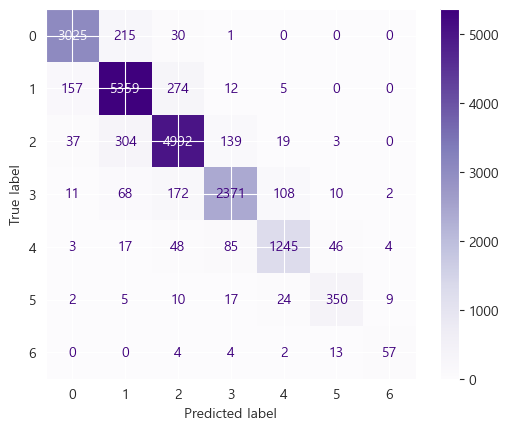

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# y_test와 y_pred_xgb는 이미 정의되어 있어야 합니다.
cnf = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf)

# ConfusionMatrixDisplay를 plot합니다.
ax = disp.plot(cmap=plt.cm.Purples)  # cmap는 변경하지 않고 그대로 사용합니다.

plt.show()